In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import statsmodels.api as sm

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [3]:
df = pd.read_csv('../input/btc2021/full_data__1__2021.csv')
df.head()

,Unnamed: 0,timestamp,Asset_ID,Asset_Name,Weight,Count,Open,High,Low,Close,Volume,VWAP,Target
0,18935914,1609459260,1,NaN,NaN,4039.0,28985.511250,29086.90,28960.0,29032.387500,163.787036,29017.664870,0.000396
1,18935928,1609459320,1,NaN,NaN,1969.0,29031.175000,29079.56,28951.5,29002.956734,98.754670,29014.703526,-0.000069
2,18935942,1609459380,1,NaN,NaN,1689.0,29002.977509,29069.39,28967.8,29005.580000,55.202131,29003.078663,-0.000137
3,18935956,1609459440,1,NaN,NaN,1146.0,29004.293750,29057.73,28971.8,29000.490000,56.575903,29006.256629,-0.000682
4,18935970,1609459500,1,NaN,NaN,2088.0,28994.918934,29031.71,28929.3,28962.285818,70.319136,28972.005783,-0.000446


## Data Preprocessing

In [4]:
from datetime import datetime

def return_datetime(timestamp):
    return datetime.fromtimestamp(timestamp)

df['date'] = df['timestamp'].apply(return_datetime)

In [5]:
cols = ['date', 'Open', 'High', 'Low', 'Close', 'Volume']
df = df[cols]
df.head()

,date,Open,High,Low,Close,Volume
0,2021-01-01 00:01:00,28985.511250,29086.90,28960.0,29032.387500,163.787036
1,2021-01-01 00:02:00,29031.175000,29079.56,28951.5,29002.956734,98.754670
2,2021-01-01 00:03:00,29002.977509,29069.39,28967.8,29005.580000,55.202131
3,2021-01-01 00:04:00,29004.293750,29057.73,28971.8,29000.490000,56.575903
4,2021-01-01 00:05:00,28994.918934,29031.71,28929.3,28962.285818,70.319136


## Data Exploration

In [6]:
# Resampling to hourly frequency
df.index = df.date
df = df.resample('H').mean()

# Resampling to daily frequency
df_day = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

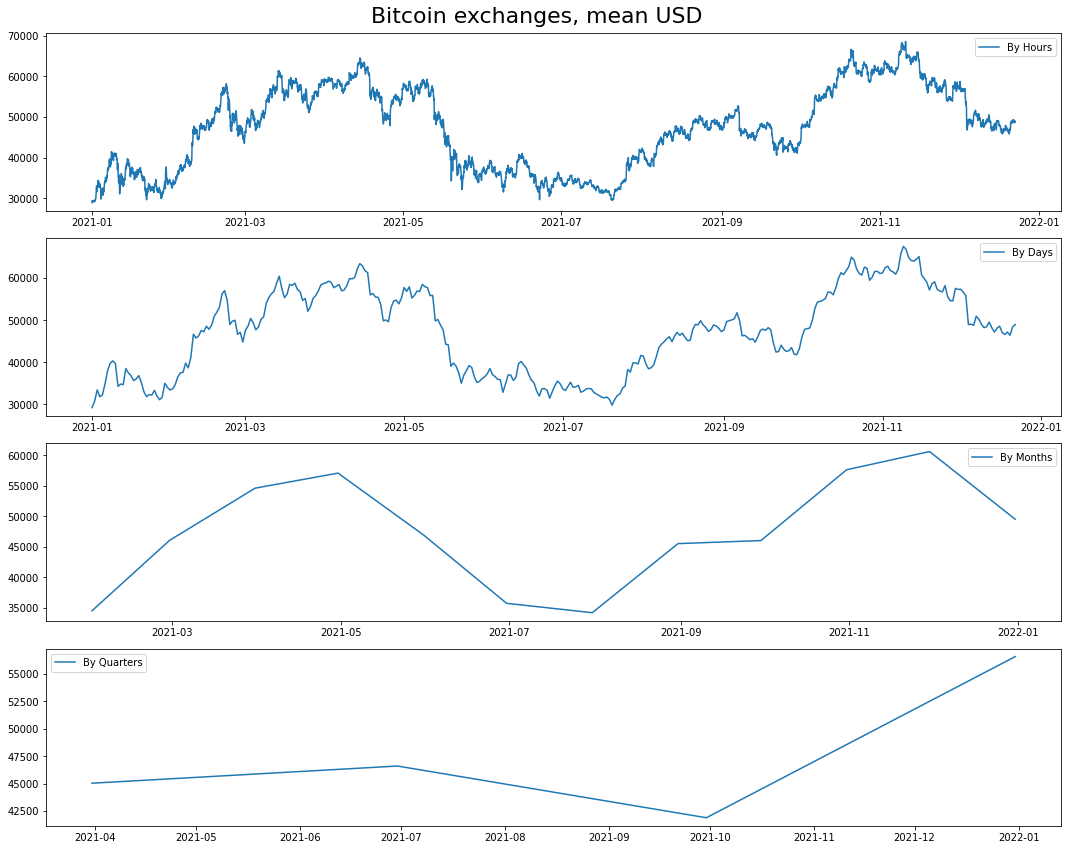

In [7]:
# PLOTS
fig = plt.figure(figsize=[15, 12])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(411)
plt.plot(df.Close, '-', label='By Hours')
plt.legend()

plt.subplot(412)
plt.plot(df_day.Close, '-', label='By Days')
plt.legend()

plt.subplot(413)
plt.plot(df_month.Close, '-', label='By Months')
plt.legend()

plt.subplot(414)
plt.plot(df_Q.Close, '-', label='By Quarters')
plt.legend()

plt.tight_layout()
plt.show()

We will predict bitcoin prices by hours to match part 1.


## Stationarity Test

In [8]:
# Stability Test (Dickey-Fuller Test)
def is_stationary(y, col='Close'):

    # "HO: Non-stationary"
    # "H1: Stationary"

    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        print(F"{col} Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        print(F"{col} Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 4)})")

In [9]:
# apply is_stationary
for col in df.columns:
    is_stationary(df[col], col)

Open Result: Non-Stationary (H0: non-stationary, p-value: 0.2043)
High Result: Non-Stationary (H0: non-stationary, p-value: 0.1744)
Low Result: Non-Stationary (H0: non-stationary, p-value: 0.2046)
Close Result: Non-Stationary (H0: non-stationary, p-value: 0.2045)
Volume Result: Stationary (H0: non-stationary, p-value: 0.0)


only **Volume** seems to be **Stationary.**

In [10]:
# Time Series Components and Stationarity Test
def ts_decompose(y, model="additive", stationary=False):
    result = sm.tsa.seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

    if stationary:
        is_stationary(y)

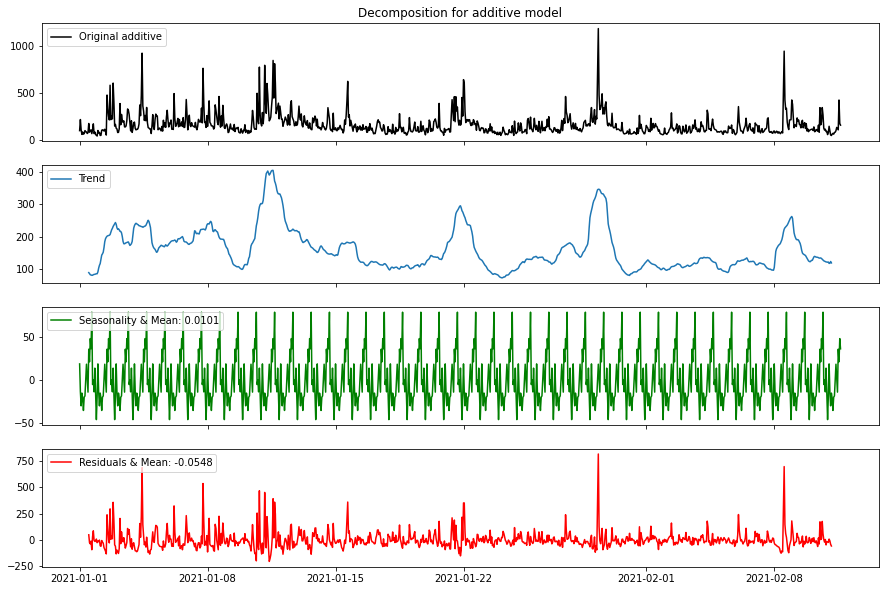

Close Result: Stationary (H0: non-stationary, p-value: 0.0)


In [11]:
# apply test decompose for volume
ts_decompose(df.Volume[:1000], stationary=True)

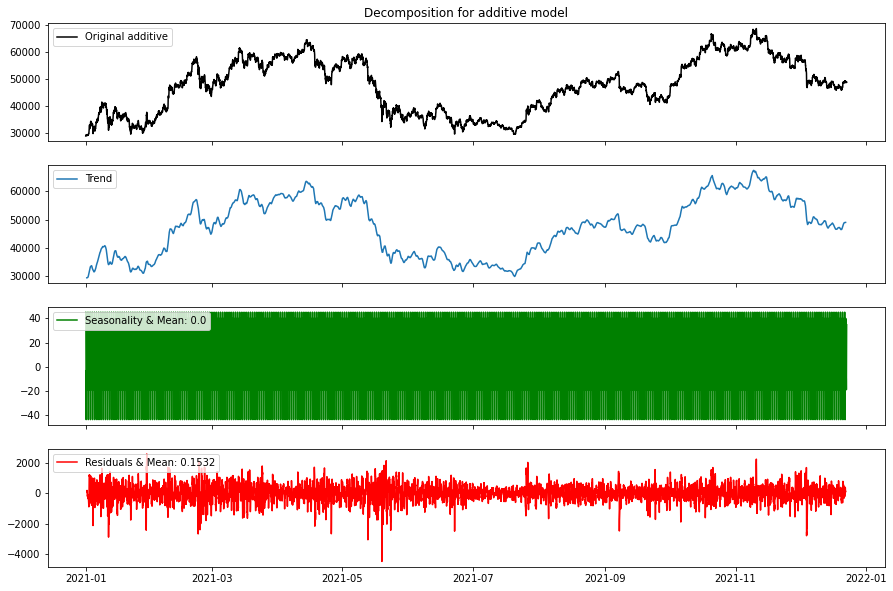

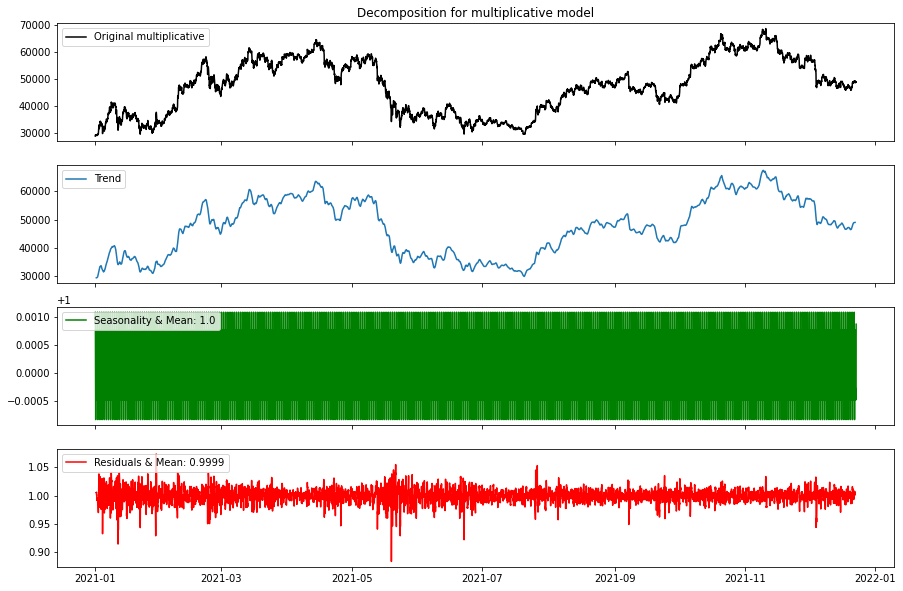

In [12]:
# Analysis for additive and multiplicative models
for model in ["additive", "multiplicative"]:
    ts_decompose(df.Close, model)

As Target **Non-Stationary**, We have to do some normalization and test it again.

## Data Normalize

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

target = scaler.fit_transform(df[['Close']])

df['Close_norm'] = target 
df['Close_diff'] = df['Close_norm'].diff()
df.fillna(0, inplace=True)

In [14]:
# apply is_stationary
is_stationary(df.Close_diff)

Close Result: Stationary (H0: non-stationary, p-value: 0.0)


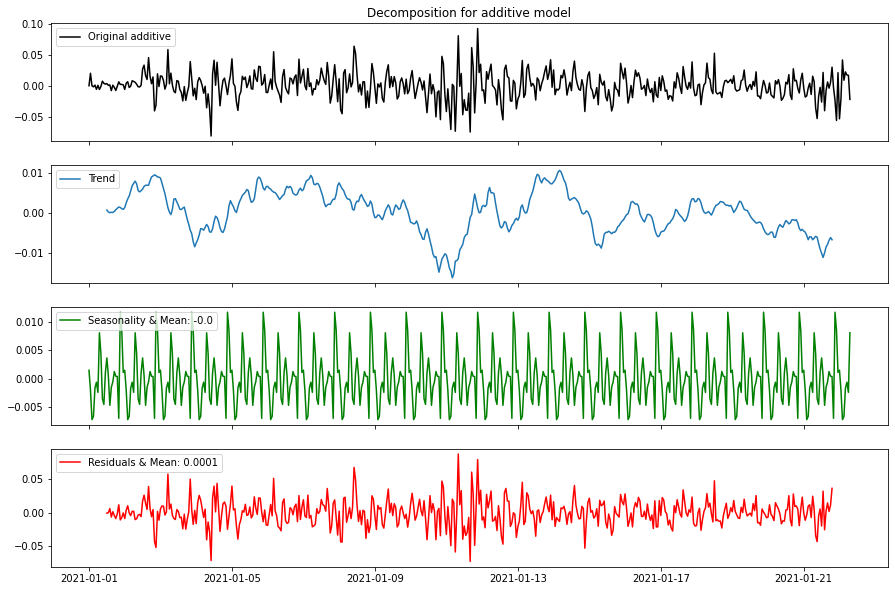

Close Result: Stationary (H0: non-stationary, p-value: 0.0)


In [15]:
# show 512 sample
ts_decompose(df.Close_diff[:512], stationary=True)

Now the data is ready for Modeling

## Model

In [16]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

from tensorflow.keras.optimizers import SGD, Adam

### Prepare Data

In [17]:
train_split = 0.9
data_len = int(target.shape[0] * train_split)

train_target = target[:data_len]
test_target = target[data_len:]

### Add TimeStamp

In [18]:
sr = 2
lb = 72*sr # hours

train_gen = TimeseriesGenerator(train_target, train_target, length=lb, sampling_rate=sr, batch_size=256)
test_gen = TimeseriesGenerator(test_target, test_target, length=lb, sampling_rate=sr, batch_size=128)

shape = train_gen[0][0].shape[1:]

### LSTM

In [19]:
# define model
model = Sequential()
#model.add(LSTM(32, return_sequences=True, input_shape=shape))
model.add(LSTM(10, input_shape=shape))
model.add(Dense(1,))

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10)                480       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [20]:
# model callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

# loss function
huber_loss = tf.keras.losses.Huber()
model.compile(loss='mse', optimizer=Adam(learning_rate=0.1))

# Traning
history = model.fit(train_gen, 
                    validation_data=test_gen, 
                    callbacks=[es, reduce_lr],
                    epochs=1000,
                    verbose=0,
                   )

Restoring model weights from the end of the best epoch.
Epoch 00202: early stopping


### Test Model

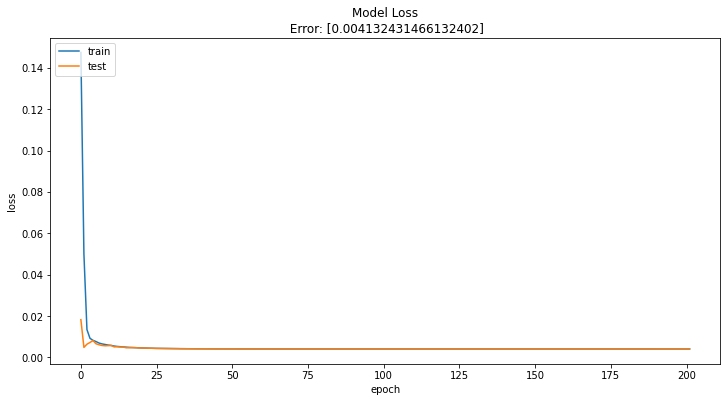

In [21]:
# summarize history for loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f"Model Loss\n Error: [{np.min(history.history['val_loss'])}]")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Predictions

In [22]:
# predict and compare
pred = scaler.inverse_transform(model.predict(test_gen))
true = scaler.inverse_transform(test_target[lb:])

print('Real Mean-Aabsolute-Error:', np.mean(abs(pred-true)))

Real Mean-Aabsolute-Error: 876.3086447115707


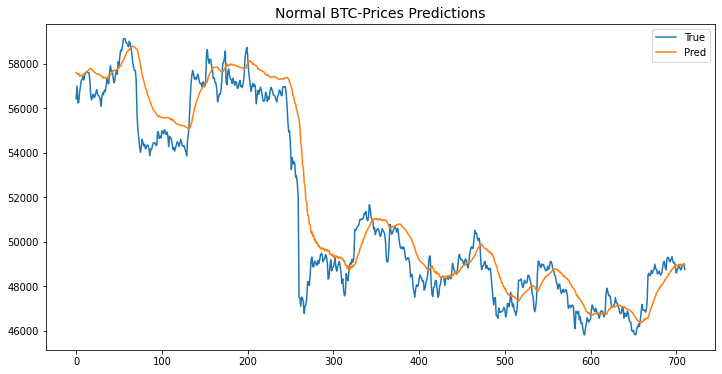

In [23]:
# plot the results
plt.figure(figsize=(12, 6))
plt.plot(true, label='True');
plt.plot(pred, label='Pred')
plt.title('Normal BTC-Prices Predictions', fontsize=14)
plt.legend();

## Conclusion:

The Real Mean-Aabsolute-Error is reasonable, and predictions fit well.